# **Assignment07 : Voice of Customer Analytics**

# **Set up**

In [1]:
!pip install pythainlp
!pip install tensorflow_text
!pip install umap-learn

     |████████████████████████████████| 11.0 MB 5.8 MB/s 
     |████████████████████████████████| 743 kB 54.3 MB/s 
     |████████████████████████████████| 4.9 MB 10.3 MB/s 
     |████████████████████████████████| 86 kB 1.6 MB/s 
     |████████████████████████████████| 1.1 MB 16.8 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=2ff4501137e4d5963e943a988c91d89c1173e301018747bfa87792fcb2dade1f
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=4b87ec0a22f4ffa73401a9b6454ca9066f813898d57cd0c15678b32059af9e0b
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built umap-learn pynndescent


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Install and import dependencies**

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 50)
import re

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import umap

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

import pythainlp
from pythainlp.corpus.common import thai_words
from pythainlp.util import Trie
import collections


In [5]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' 
#'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' for a large model

model = hub.load(module_url)

In [6]:
df = pd.read_csv('/content/drive/My Drive/BADS7105/Wongnai Reviews - Small.csv')

In [7]:
df.head()

,Review ID,Review
0,1,เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีวันนึงเด...
1,2,Art of Coffee Kasetsart เป็นร้านกาแฟรสชาติเยี่...
2,3,กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่ค...
3,4,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...
4,5,ชอบมาทานร้านนี้ถ้าอยากกินอาหารเวียดนามใกล้บ้าน...


#**Document embedding and dimension reduction**

In [8]:
#embed sentences using Universal Sentence Encoder (USE)

embed_comments_array = model(df['Review'].values).numpy()
embed_comments_array

array([[ 0.08993827,  0.01941084,  0.03787038, ..., -0.03488849,
         0.06299512,  0.04635989],
       [ 0.00634244,  0.00814594,  0.03071941, ..., -0.01478723,
        -0.03080936, -0.03316405],
       [ 0.0633687 , -0.02027139, -0.05077003, ..., -0.06530775,
        -0.00952999, -0.03439987],
       ...,
       [ 0.08775924,  0.03609736,  0.01263062, ..., -0.03102781,
        -0.03361677,  0.01928871],
       [ 0.05691195,  0.05381691, -0.0399575 , ..., -0.06598807,
        -0.05390478, -0.01037725],
       [ 0.0777048 ,  0.05080631,  0.02680681, ..., -0.0061413 ,
        -0.01313567,  0.02236264]], dtype=float32)

#**Document clustering using KMeans**

Text(0, 0.5, 'WCSS')

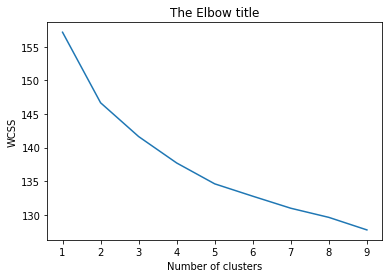

In [9]:
#run kmeans with various number of k. evaluate no. of k based on the elbow plot

wcss=[]
max_k = 10
for i in range(1, max_k):
  kmeans = KMeans(i)
  kmeans.fit(embed_comments_array)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1, max_k)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

Choose K = 4, divided in to 4 clusters

In [10]:
#run kmeans with no. of clusters you see fit the most

k = 4

kmeans = KMeans(n_clusters = k)
kmeans.fit(embed_comments_array)

df['KMeans ID'] = kmeans.labels_

In [11]:
#merge all reviews of each cluster into one big sentence 

df_kmeans = pd.DataFrame(columns=["KMeans ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(df['Review'][df['KMeans ID'] == i].to_string())
  df_kmeans.loc[len(df_kmeans)] = row

In [12]:
df_kmeans

,KMeans ID,texts
0,0,2 กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูห...
1,1,3 วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออก...
2,2,13 เคยเป็นไหมกันไหมคะ หลังอาหารมื้อใหญ่ ต่...
3,3,0 เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีว...


Remove special characters

In [13]:
#create regex compiler for removal of a character you don't want

special_characters = "/[!@#$%^&*']/g"

specialchar_pattern = re.compile(special_characters)

Remove emojicon

In [14]:
#create regex compiler for removal of any emoji

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

Remove any numbers

In [15]:
#create regex compiler for removal of digit

number_pattern = re.compile("[0-9]")

Remove white space

In [16]:
#create regex compiler for removal of white space

space_pattern = re.compile("\s+")

Remove dot

In [17]:
#create regex compiler for removal of .

dot_pattern = re.compile(r"\.+")

Remove back slash

In [18]:
#create regex compiler for removal of \

backslash_pattern = re.compile(r"\\+")

#**Word Tokenization**

In [19]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization

stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = ['u', 'b', 'n', 'nn', 'nn-', '\n', 'ร้าน', 'กิน', 'ทาน', 'ผม','กก','สวัสดี', 'เก','ก','า','ร้า','เรา','ฉัน']
screening_words = stopwords + removed_words

new_words = {"สตารบัก", "ปลาร้า","ไม่อร่อย","เรา","หนอ","เสนอ"}

words = new_words.union(thai_words())

custom_dictionary_trie = Trie(words)

def tokenize_to_list(sentence):
  merged = []
  words = pythainlp.word_tokenize(str(sentence), engine='longest', custom_dict=custom_dictionary_trie)
  for word in words:
    if word not in screening_words:
      merged.append(word)
  return merged

In [20]:
#clean and tokenize sentences. count the occurences of each word

df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_kmeans['texts_tokenized'] = df_kmeans['texts'].apply(lambda x: tokenize_to_list(x))
df_kmeans['texts_count'] = df_kmeans['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [21]:
#results of tokenization
pd.set_option('display.max_colwidth', 50)

df_kmeans

,KMeans ID,texts,texts_tokenized,texts_count
0,0,กวงทะเลเผาอาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่คส...,"[วง, ทะเล, เผา, อาหารทะเล, เค้า, สด, เนื้อ, ปู...","[(ร้านอาหาร, 8), (อาหาร, 6), (ซอย, 6), (ราคา, ..."
1,1,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...,"[มีโอกาส, ตื่น, เช้า, โอกาส, ออกมา, หา, อะ, ไช...","[(ชอบ, 7), (อร่อย, 7), (รีวิว, 6), (ครั้งแรก, ..."
2,2,เคยเป็นไหมกันไหมคะหลังอาหารมื้อใหญ่ต่อให้อิ่เป...,"[ไหม, ไหม, หลังอาหาร, มื้อ, อิ่, เครื่องดื่ม, ...","[(ชา, 18), (ไข่มุก, 14), (นม, 12), (เครื่องดื่..."
3,3,เป็นคนที่ชอบทานMacchiatoเป็นประจำมีวันนึงเดArt...,"[คน, ชอบ, macchiato, เป็นประจำ, นึง, เด, artof...","[(ร้านกาแฟ, 20), (กาแฟ, 18), (คน, 5), (บรรยากา..."


#**Understanding each clusters**

Show top keywords of each cluster

In [22]:
top_N_words = 20

for i in range(0, len(df_kmeans)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_kmeans['texts_count'][i])[:top_N_words]}\n")

#tune a model by remove unwanted characters and words and add more words to a custom dictionary

Cluster ID : 0

Most common words include : [('ร้านอาหาร', 8), ('อาหาร', 6), ('ซอย', 6), ('ราคา', 5), ('รีวิว', 4), ('อร่อย', 4), ('รสชาติ', 4), ('ส้มตำ', 3), ('บ้าน', 3), ('ไทย', 3), ('ยำ', 3), ('แซ่บ', 3), ('คน', 3), ('รอบ', 3), ('สาขา', 3), ('เมนู', 3), ('น้ำ', 3), ('กาแฟ', 3), ('วง', 2), ('เพื่อนๆ', 2)]

Cluster ID : 1

Most common words include : [('ชอบ', 7), ('อร่อย', 7), ('รีวิว', 6), ('ครั้งแรก', 5), ('ร้านอาหาร', 5), ('แวะ', 4), ('ลอง', 4), ('ซื้อ', 4), ('มีโอกาส', 3), ('เช้า', 3), ('โอกาส', 3), ('หา', 3), ('บ้าน', 3), ('ถนน', 3), ('คาเฟ่', 3), ('คิว', 3), ('แถว', 3), ('เมือง', 3), ('นะคะ', 3), ('พาย', 3)]

Cluster ID : 2

Most common words include : [('ชา', 18), ('ไข่มุก', 14), ('นม', 12), ('เครื่องดื่ม', 4), ('รีวิว', 3), ('ลอง', 3), ('ติด', 3), ('ไต้หวัน', 3), ('ไหม', 2), ('ชาเขียว', 2), ('นิว', 2), ('คุง', 2), ('เจอ', 2), ('ochaya', 2), ('มากๆ', 2), ('aprilstore', 2), ('ตั้งอยู่', 2), ('สยาม', 2), ('คน', 2), ('สไตล์', 2)]

Cluster ID : 3

Most common words include : [('ร้า

Show the original review for the interesring key words.

In [23]:
pd.set_option('display.max_colwidth', None)
df[df["Review"].str.contains("ไร้")]

,Review ID,Review,KMeans ID
71,72,จริงๆจะไปกินร้านอื่นครับที่อยู่ในซอยเดียวกัน แต่ดันแวะร้านนี้ก่อนถึงที่หมาย 555+ บรรยากาศภายนอกตอนค่ำผมนึึกว่าร้านคาราโอเกะนั่งดิ๊งค์ซะอีก ก้อเล่นติดไฟเป็นสีๆกระพริบๆ แต่พอเอาเข้าจริงต้องบอกว่าเก๋ไก๋ สไตส์ลูกทุ่งคันทรี กินกันตรงชั้น2ระเบียงร้าน ผมได้ลอง3เมนู จานแรก ส้มตำปูม้า รสชาติแซ่บดี ใช้ปูุม้าขนาดใหญ่น้องๆsizeปูนึ่งทีเดียว ปูสด เนื้อเยอะสะใสเนื้อปูหวานฉ่ำไม่คาว สุดยอดมั๊กๆ จานทีี่2 กุ้งแช่น้ำปลา จานนี้ส่วนตัวคิดว่ารสชาติธรรมดา กุ้งตัวเล็กๆไปหน่อย แต่เขาทำสะอาดดี ผ่าเอาเส้นดำหลังกุ้งออกเกลี้ยงเลย ซึ่งผิดกับร้านอื่นๆทีี่เคยกินทีี่มักจะผ่าให้แต่ไม่เอาเส้นหลังออกให้ครับ จานที่3 ปลาช่อนระเบียงไม้ วิธีทำเหมือนกะนึ่งมะนาว แต่เป็นต้มยำน้ำข้น ข้นคักจริงๆใส่นมสดหอมมันมากมาย ปลาช่อนสดตัวใหญ่sizeกำลังดี เนื้อใสไม่ยุยไร้คาว อร่อยมากกก ซึ่งเขาว่าเป็นเมนูเอกของร้าน สมราคาคุยครับ อร่อยจริงๆคอนเฟิร์ม ที่จอดรถสะดวก บริการดี เจ้าของเป็นกันเอง ราคาผมว่า ไม่แพงนะ ร้านอยู่ลึกไปหน่อยแต่ชิมรสชาติแล้วต้องบอกว่า ไม่ผิดหวังครับ,0
204,205,"สวัสดีเพื่อนๆพี่ๆชาวนักชิมแห่ง wongnai.com ทุกท่านครับ \nผม Captain Ton ขออาสาส่งความสุขให้ทุกท่านกันอีกครั้งครับ \nสามารถติดตามรีวิวต่างๆของผมได้ที่ http://www.facebook.com/CaptainTonEatTravel และ IG ค้นหา Captain_Ton ได้เลยครับ มาติดตามความอร่อยกับผมกันเยอะๆนะครับ \n\nคำว่า""บุฟเฟต์"" ราวกับความสุขของเหล่าคนชอบกินและชอบความคุ้ม วันนี้ผมจะพาทุกคนมาหาความสุขกันที่ร้าน MK Buffet สาขาฟิวเจอร์ปาร์รังสิตกันครับเพราะว่าที่นี่เป็นสาขาเดียวที่มีสุกี้บุฟเฟ่ต์ ให้ทานได้ไม่อั้นตลอดทั้งวัน และทุกวันทำการ ต่างจากสาขาอื่นที่ยกเว้นเสาร์-อาทิตย์บ้าง แต่มาที่นี่ได้ทานชัวร์ครับ \n\nส่วนราคานั้นก็มี 2 ราคาตามช่วงเวลาได้แก่ 10.00-17.00ราคา319บาท net และหลัง 17.00เป็นต้นไป 349บาท net \nจะไปทานเวลาไหนต้องจ่ายเท่าไหร่ก็ต้องวางแผนให้ดีนะครับ ส่วนเรื่องอาหารนั้นก็มีมากมายหลากหลายมาก ดูจากรูปแล้วกันนะครับ \n\nเข้ามาถึงในร้านก็เลือกที่นั่งได้ตามสะดวกเลย แต่ว่ามาเที่ยงๆแบบนี้คนเยอะมากหาที่นั่งแทบไม่ได้เลย เข้ามานั่งเกือบในสุดเลย \n\nสักพักพนักงานก็จะมาสอบถามว่ารับเป็นบุฟเฟต์ หรือ A la carte มาถึงถิ่นขนาดนี้แล้วก็ต้องจัดเต็ม!!! \nก่อนทานก็ต้องอ่านกฎระเบียบการทานด้วยนะครับ มิเช่นนั้นท่านอาจจะถูกปรับเอาได้ เดี๋ยวหาว่าไม่เตือนนะ \nสั่งเมนูที่ท่านคิดว่าอยากทาน อร่อย และคุ้ม จัดเต็มด้วย สมุดตามในฉัน(เมนู)ได้เลย \n\nไม่นานนักหม้อน้ำซุปสีแดงอันเป็นเอกลักษณ์ก็ถูกยกออกมาพร้อมน้ำซุปในหม้อ ปิดฝาเอาไว้ก่อน รอเดือดก่อนนะ \nน้ำจิ้มของMK ก็หนีไม่พ้นเจ้า2สูตร ทั้งน้ำจิ้มสุกี้สูตรดั้งเดิมและสูตรเด็กน้อย รสชาติที่คุ้นเคย \nแต่รู้สึกว่าสูตรดั้งเดิมมันจะเปรี้ยวๆไปหน่อยนะหรือเค้าปรับสูตรใหม่เพื่อลดมะนาวหว่า ??? ช่างมันเถอะ \nส่วนใครที่เคยบ่นว่าMKหวงพริก หวงกระเทียม แต่สาขาที่นี่ไม่ใช่นะครับ ให้มาเป็นถาดวางไว้บนโต๊ะเติมได้ตามใจเลย สะใจดีจัง \n\nน้ำดื่มของที่นี่ก็มีหลายอย่างนะครับ ทั้งชาจีนต้นตำรับ ชานมสูตรเข้มขันสุดๆ กาแฟ ชาเขียว และน้ำอัดลมมีให้เลือกค่อนข้างหลากหลายดีครับ แต่ที่ผมติดใจที่สุดก็ต้องเจ้านี่เลย ชานมสูตรเข้มข้นมาก ถ้าใส่ไข่มุกอีกหน่อยนี้ร้านดังๆเจ๊งแน่นอน พูดเล่นนะครับแต่มันอร่อยจริงๆนะ \n\nไม่นานนักอาหารที่สั่งไปค่อยๆทยอยมาแล้วครับ มาในทาวเวอร์สีแดงตามแบบฉบับดั้งเดิม และติ่มซำเนื้อแน่นรสชาติเยี่ยมที่ผมเดินทางมาถึงที่นี่ก็เพื่อเจ้าสิ่งนี้นี่แหละครับ จิ้มกับจิ๊กโฉ่วสูตรเฉพาะของทางร้าน อร่อยสมกับที่เดินทางมาจริงๆ \n\nขนมจีบหมูอร่อยแป้งบางเนื้อแน่นสุดๆ ขนมจีบกุ้งเนื้อแน่นเคี้ยวกี่คำก็เจอกุ้ง ฮะเก่าเนื้อแน่นแต่แป้งแต่แป้งเละไปหน่อยไม่ค่อยปลื้ม \n\nส่วนหมี่หยกของร้าน MK เหมือนจะเป็นเกรด B หรืออย่างไร เส้นใหญ่ เหนียว กระด้าง ติดกันเป็นพรืด ไม่เหมือนที่เคยทานเมื่อก่อน ผิดหวังเล็กน้อย \n\nกางออกของสดมาดูกันจะๆ ว่ามีอะไรบ้าง ดูสด น่าอร่อยไม่มีปัญหาเรื่องกลิ่นและสีสันครับ นำจับต้มให้สุกตามระเบียบ คงไม่มีใครทานดิบๆเย็นๆสินะ อิอิ \n\nจับเนื้อมาลวกๆลองชิมดูครับ นุ่มเด้งมากแต่ไม่ค่อยชอบเท่าไหร่ส่วนตัวคิดว่าเหมือนเนื้อปลอมเลย มันเด้งๆไร้กลิ่นเนื้อชืดมากเลยครับ แต่พอทานกับน้ำจิ้มของที่นี่ก็พอถูไถไปได้ \n\nทานไปทานมาชักเริ่มเบื่อ เริ่มเลี่ยน สั่งซาลาเปาหมูแดงมา1เข่ง ไส้อร่อยมากครับ แต่แป้งค่อนข้างจืด และกระด้าง สรุปคือไม่ผ่านครับ \n\nอิ่มแล้วก็ตบท้ายด้วยของหวานอย่างไอศกรีมเชอร์เบตมะนาว และทับทิมกรอบครับ ไอศกรีมเชอร์เบตของที่นี่เข้มข้นหอมกลิ่นมะนาวดีครับ \n\nและทับทิมกรอบที่น้ำเเข็งมาล้นหน้า รสชาติใสๆ หอมกลิ่นควันเทียนเล็กน้อย ผสมเนื้

In [24]:
df[df["Review"].str.contains("ไม่อร่อย")]

Review ID  ... KMeans ID
2            3  ...         0
6            7  ...         0
11          12  ...         3
16          17  ...         3
34          35  ...         1
85          86  ...         1
116        117  ...         1
135        136  ...         0
142        143  ...         1
149        150  ...         1
170        171  ...         3
235        236  ...         0
246        247  ...         1
265        266  ...         0
271        272  ...         2
275        276  ...         0
279        280  ...         1
284        285  ...         1

[18 rows x 3 columns]